In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/d2nn

/content/drive/My Drive/d2nn


In [ ]:
import tensorflow as tf
import numpy as np
from math import pi
from tensorflow.keras import layers
from scipy.fftpack import fft2
import time
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import pprint
from tempfile import TemporaryFile

In [ ]:
import pickle
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 28, 28)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Mon Jul 27 17:38:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class grating_layer(layers.Layer):
    ''' Generates grating multiplication layer
        Spatially multiplies input with grating layer
    '''
    def __init__(self, period, grating_type):
        super(grating_layer, self).__init__()
        self.period = period
        self.grating_type = grating_type

    def call(self, x):
        if self.grating_type == 'sin_phase':
            self.grating = self.generate_sinudoidal_phase_grating(x.get_shape()[1])
        elif self.grating_type == 'bin_phase':
            self.grating = self.generate_binary_phase_grating(x.get_shape()[1])
        elif self.grating_type == 'bin':
            self.grating = self.generate_binary_grating(x.get_shape()[1])
        return tf.map_fn(self.apply_grating, x)

    def apply_grating(self, x):
        return tf.math.multiply(x, self.grating)

    def generate_binary_grating(self, image_dimension):
        number_of_gratings = tf.constant([image_dimension//self.period], 'int64')
        #unit_grating = tf.constant(np.array([0.0] + [1.0]*(self.period - 2) + [0.0]), 'complex64')
        grating_1d = tf.cast(tf.constant(np.array([0, 1]*int((28*self.period)//2))), 'complex64')
        [grating_2dx, grating_2dy] = tf.meshgrid(grating_1d, grating_1d)
        grating_2d = tf.math.multiply(grating_2dx, grating_2dy)
        return tf.cast(grating_2d, 'complex64')

    def generate_sinudoidal_phase_grating(self, image_dimension):
        number_of_gratings = tf.constant([image_dimension//self.period], 'int64')
        x = tf.linspace(0.0, 2*pi, self.period)
        unit_grating = tf.math.sin(x, 'complex64')
        grating_1d = tf.tile(unit_grating, number_of_gratings, 'complex64')
        [grating_2dx, grating_2dy] = tf.meshgrid(grating_1d, grating_1d)
        grating_2d = tf.math.multiply(grating_2dx, grating_2dy)
        return tf.cast(tf.math.exp(grating_2d), 'complex64')

    def generate_binary_phase_grating(self, image_dimension):
        number_of_gratings = tf.constant([image_dimension//self.period], 'int64')
        #unit_grating = tf.constant(np.array([0.0] + [1.0]*(self.period - 2) + [0.0]), 'complex64')
        grating_1d = tf.cast(tf.constant(np.array([0, pi]*int((28*self.period)//2))), 'complex64')
        [grating_2dx, grating_2dy] = tf.meshgrid(grating_1d, grating_1d)
        grating_2d = tf.math.multiply(grating_2dx, grating_2dy)
        return tf.cast(tf.math.exp(grating_2d), 'complex64')

class batch_normalize_2_images(layers.Layer):

    def __init__(self):
        super(batch_normalize_2_images, self).__init__()

    def call(self, x):
        epsilon = 1e-3
        stack = tf.math.divide(x, tf.constant(2.0, 'complex64'))
        batch_mean2, batch_var2 = tf.nn.moments(x=stack,axes=[0])
        batch_mean2 = tf.cast(batch_mean2, 'float32')
        batch_var2 = tf.cast(batch_var2, 'float32')
        scale2 = tf.cast(tf.Variable(tf.ones(stack.get_shape())), 'float32')
        beta2 = tf.cast(tf.Variable(tf.zeros(stack.get_shape())), 'float32')
        BN_x = tf.nn.batch_normalization(x, batch_mean2, batch_var2, beta2, scale2, epsilon)
        return BN_x

class normalize_2_complex_images(layers.Layer):

    def __init__(self):
        super(normalize_2_complex_images, self).__init__()

    def call(self, x):
        norm_x = tf.map_fn(self.apply_conv, x)
        return norm_x

    def apply_conv(self, x):
        x_max = tf.reduce_max(input_tensor=tf.abs(x))
        norm_x = tf.math.divide(x, tf.cast(x_max, 'complex64'))
        return norm_x

class scale_2_complex_images(layers.Layer):
    ''' Resizes images to original shape x scale
            Original shape x scale must be integer number
            Tensorflow does not support resizing complex valued tensors
            tf.image.resize 
    '''
    def __init__(self, scale):
        super(scale_2_complex_images, self).__init__()
        self.scale = scale

    def call(self, x):
        sx = tf.map_fn(self.apply_scale, x)
        return sx

    def apply_scale(self, x):
        ''' Takes 2-D Tensor, returns scaled 2-D Tensor '''
        s = tf.identity(x)
        s_shape = tf.shape(input=s)
        s = tf.reshape(s, [s_shape[0], s_shape[1], 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale, 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.transpose(a=s, perm=[0, 2, 1])
        s = tf.reshape(s, [s_shape[0]*self.scale, s_shape[1]*self.scale])
        return s

In [ ]:
class propagation_layer(layers.Layer):
    ''' Propagator layer with fft convolution implementation
        fft empirically determined to be faster for large kernels
        Input to fsp layer must be physical values
    '''
    def __init__(self, source_grid_size, lc_array_size, dx, dist, wavelength, prop_type):
        super(propagation_layer, self).__init__()
        self.source_grid_size = source_grid_size
        self.lc_array_size = lc_array_size
        self.dx = dx
        self.prop_dist = dist
        #self.prop_dist = tf.Variable(initial_value = 0.001, trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 2e-3), dtype = 'float32')
        self.wavelength = wavelength
        self.propagator = self.make_TF_propagator()

    def make_TF_propagator(self):
        L = self.lc_array_size
        dx = self.dx
        prop_dist = self.prop_dist
        wavelength = self.wavelength
        fx = np.arange(-1/(2*dx), 1/(2.*dx), 1/L)
        [FX, FY] = np.meshgrid(fx, fx)
        H = np.exp(-1j*pi*wavelength*prop_dist*(np.square(FX) + np.square(FY)))
        H = np.fft.fftshift(H)
        return tf.constant(H, 'complex64')

    def call(self, x):
        x = tf.cast(x, 'complex64')
        conv_x = tf.map_fn(self.apply_conv, x)
        return conv_x

    def apply_conv(self, x):
    	  conv_x = self.conv2dfft(self.propagator, x)
    	  return conv_x
             
    def conv2dfft(self, A, B):
    	B = tf.signal.fft2d(tf.signal.fftshift(B))
    	fftAB = tf.math.multiply(A, B)
    	return tf.signal.ifftshift(tf.signal.ifft2d(fftAB))

class dmd_layer(layers.Layer):
    
    def __init__(self, num_weights, scale):
        super(dmd_layer, self).__init__()
        num_weights = int(num_weights)
        self.scale = scale
        self.transmission = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 1))

    def call(self, x):
        self.batch_size = x.get_shape()[0]
        scaled_weights = self.scale_weights() 
        return self.dmd(x, scaled_weights)

    def scale_weights(self):
        ''' Scales weights from nxn to n*scale x n*scale
            For example, scales 28x28 to 2800x2800 if scale = 100, each 1 pixel
                is scaled to 100x100
        '''
        multiplier = int(1/self.scale)
        w = tf.identity(self.transmission)
        w_shape = tf.shape(input=w)
        w = tf.reshape(w, [w_shape[0], w_shape[1], 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier, 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.transpose(a=w, perm=[0, 2, 1])
        w = tf.reshape(w, [1, w_shape[0]*multiplier, w_shape[1]*multiplier])
        w = tf.tile(w, [self.batch_size, 1, 1])
        return w
    
    def dmd(self, x, scaled_weights):
        return tf.math.multiply(x, tf.cast(scaled_weights, 'complex64'))

class phaseret_layer(layers.Layer):
    
    def __init__(self, num_weights, scale):
        super(phaseret_layer, self).__init__()
        num_weights = int(num_weights)
        self.scale = scale
        self.phase = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True, constraint=lambda t: tf.clip_by_value(t, 0, 2*pi))

    def call(self, x):
        self.batch_size = x.get_shape()[0]
        scaled_weights = self.scale_weights() 
        return self.phaseret(x, scaled_weights)

    def scale_weights(self):
        ''' Scales weights from nxn to n*scale x n*scale
            For example, scales 28x28 to 2800x2800 if scale = 100, each 1 pixel
                is scaled to 100x100
        '''
        multiplier = int(1/self.scale)
        w = tf.identity(self.phase)
        w_shape = tf.shape(input=w)
        w = tf.reshape(w, [w_shape[0], w_shape[1], 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier, 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.transpose(a=w, perm=[0, 2, 1])
        w = tf.reshape(w, [1, w_shape[0]*multiplier, w_shape[1]*multiplier])
        w = tf.tile(w, [self.batch_size, 1, 1])
        return w
    
    def phaseret(self, x, scaled_weights):
        return tf.math.multiply(x, tf.math.exp(tf.cast(scaled_weights, 'complex64')))

class eval_layer(layers.Layer):
    ''' Converts output to one hot form
        Applies softmax

        slice matrix/unpad
        pool
    '''
    def __init__(self):
        super(eval_layer, self).__init__()

    def call(self, x):
        Ix = tf.cast(tf.math.square(tf.math.abs(x)), 'float32')
        r = tf.map_fn(self.eval, Ix)
        r = tf.cast(r, 'float32')
        return r

    def eval(self, Ix):
        # im = self.unpad(Ix)
        im = Ix
        ws = im.shape[0]//4
        pooled =  tf.nn.pool(input=tf.cast(tf.reshape(im,
                            [1, im.shape[0], im.shape[1], 1]),'float32'),
                            window_shape = (ws, ws), pooling_type = 'AVG',
                            padding = 'SAME', strides = [ws, ws])
        pooled = tf.reshape(tf.reshape(pooled, [4, 4]), [1, 16])[0][6:16]
        pooled = tf.cast(pooled, 'float32')
        return pooled

    # def eval_5(self, Ix):
    #     # im = self.unpad(Ix)
    #     im = Ix
    #     ws = im.shape[0]//5
    #     pooled =  tf.nn.pool(input=tf.cast(tf.reshape(im,
    #                         [1, im.shape[0], im.shape[1], 1]),'float32'),
    #                         window_shape = (ws, ws), pooling_type = 'AVG',
    #                         padding = 'SAME', strides = [ws, ws])
    #     indices = np.array([0, 3, 2, 1, 4, 7, 6, 5, 8, 11])
    #     pooled = tf.gather(tf.reshape(tf.reshape(pooled, [5, 5]), [1, 25])[0], indices)
    #     pooled = tf.cast(pooled, 'float32')
    #     return pooled

In [ ]:
class d2nn_model(object):
    def __init__(self):
        #super(YourModel, self).__init__()
        self.num_epoch = 1
        self.batch_size = 64
        self.log_step = 100
        self.lr = 2.5e-3
        self._build_model()

    def m(self):

        input_shape = 28
        wavelength = 690e-9
        lc_size = 2e-6
        prop_dist = 5e-3

        im_rescale = 10
        pixels_per_lc = 1

        scale1 = scale_2_complex_images(im_rescale*pixels_per_lc)
        #grating = grating_layer(8, 'sin_phase')
        grating = lambda x: x
        num_weights = input_shape*im_rescale
        #dmd = phaseret_layer(num_weights, 1.0/pixels_per_lc)
        dmd = dmd_layer(num_weights, 1.0/pixels_per_lc)
        normalize = normalize_2_complex_images()
        bn = batch_normalize_2_images()

        source_grid_size = input_shape*im_rescale*pixels_per_lc
        lc_array_size = input_shape*im_rescale*lc_size
        dx = lc_size/pixels_per_lc
        propagate1 = propagation_layer(source_grid_size, lc_array_size, dx, prop_dist, wavelength, 'TF')
        evaluate = eval_layer()
        
        with tf.compat.v1.variable_scope('scale1'):
            self.x0 = scale1(self.X)
        with tf.compat.v1.variable_scope('b1'):
            self.xl1 = dmd(self.x0)
            self.xg1 = grating(self.xl1)
            self.xp1 = propagate1(self.xg1)
            #self.xn1 = normalize(self.xp1)
        with tf.compat.v1.variable_scope('b2'):
            self.xl2 = dmd(self.xp1)
            self.xg2 = grating(self.xl2)
            self.xp2 = propagate1(self.xg2)
            #self.xn2 = normalize(self.xp2)
        with tf.compat.v1.variable_scope('b3'):
            self.xl3 = dmd(self.xp2)
            self.xg3 = grating(self.xl3)
            self.xp3 = propagate1(self.xg3)
            # self.xn3 = normalize(self.xp3)
        with tf.compat.v1.variable_scope('b4'):
            self.xl4 = dmd(self.xp3)
            self.xg4 = grating(self.xl4)
            self.xp4 = propagate1(self.xg4)
            #self.xn4 = normalize(self.xp4)
        with tf.compat.v1.variable_scope('b5'):
            self.xl5 = dmd(self.xp4)
            self.xg5 = grating(self.xl5)
            self.xp5 = propagate1(self.xg5)
            self.xn5 = normalize(self.xp5)
        # with tf.compat.v1.variable_scope('b6'):
        #     self.xl6 = dmd(self.xp5)
        #     self.xg6 = grating(self.xl6)
        #     self.xp6 = propagate1(self.xg6)
        #     # self.xn6 = normalize(self.xp6)
        # with tf.compat.v1.variable_scope('b7'):
        #     self.xl7 = dmd(self.xp6)
        #     self.xg7 = grating(self.xl7)
        #     self.xp7 = propagate1(self.xg7)
        #     self.xn7 = normalize(self.xp7)
        # with tf.compat.v1.variable_scope('b8'):
        #     self.xl8 = dmd(self.xn7)
        #     self.xg8 = grating(self.xl8)
        #     self.xp8 = propagate1(self.xg8)
        #     self.xn8 = normalize(self.xp8)
        # with tf.compat.v1.variable_scope('b9'):
        #     self.xl9 = dmd(self.xn8)
        #     self.xg9 = grating(self.xl9)
        #     self.xp9 = propagate1(self.xg9)
        #     self.xn9 = normalize(self.xp9)
        # with tf.compat.v1.variable_scope('b10'):
        #     self.xl10 = dmd(self.xn9)
        #     self.xg10 = grating(self.xl10)
        #     self.xp10 = propagate1(self.xg10)
        #     self.xn10 = normalize(self.xp10)
        # with tf.compat.v1.variable_scope('b11'):
        #     self.xl11 = dmd(self.xn10)
        #     self.xg11 = grating(self.xl11)
        #     self.xp11 = propagate1(self.xg11)
        #     self.xn11 = normalize(self.xp11)
        # with tf.compat.v1.variable_scope('b9'):
        #     self.xl9 = dmd(self.xn8)
        #     self.xg9 = grating(self.xl9)
        #     self.xp9 = propagate1(self.xg9)
        #     self.xn9 = normalize(self.xp9)
        # with tf.compat.v1.variable_scope('b10'):
        #     self.xl10 = dmd(self.xn9)
        #     self.xg10 = grating(self.xl10)
        #     self.xp10 = propagate1(self.xg10)
        #     self.xn10 = normalize(self.xp10)
        # with tf.compat.v1.variable_scope('b11'):
        #     self.xl11 = dmd(self.xn10)
        #     self.xg11 = grating(self.xl11)
        #     self.xp11 = propagate1(self.xg11)
        #     self.xn11 = normalize(self.xp11)
        # with tf.compat.v1.variable_scope('b12'):
        #     self.xl12 = dmd(self.xn11)
        #     self.xg12 = grating(self.xl12)
        #     self.xp12 = propagate1(self.xg12)
        #     self.xn12 = normalize(self.xp12)
        with tf.compat.v1.variable_scope('eval1'):
            self.result = evaluate(self.xn5)
        return self.result

    def _input_ops(self):
        # Placeholders
        self.X = tf.compat.v1.placeholder(tf.complex64, [self.batch_size, None, None])
        self.Y = tf.compat.v1.placeholder(tf.int64, [self.batch_size])
        self.is_train = tf.compat.v1.placeholder(tf.bool)
        self.keep_prob = tf.compat.v1.placeholder(tf.float32)

    def _build_optimizer(self):
        self.train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss_op)
        #self.train_op = tf.train.GradientDescentOptimizer(self.lr*10).minimize(self.loss_op)

    def _loss(self, labels, logits):
        self.loss_op = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(tf.one_hot(self.Y,10)), logits=self.result))

    def _build_model(self):
        # Define input variables
        self._input_ops()
        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)
        # Build a model and get logits
        logits = self.m()
        # Compute loss
        self._loss(labels, logits)
        # Build optimizer
        self._build_optimizer()
        # Compute accuracy
        predict = tf.argmax(input=logits, axis=1)
        correct = tf.equal(predict, self.Y)
        self.confusion_matrix = tf.math.confusion_matrix(labels=self.Y, predictions=predict, num_classes=10)
        self.accuracy_op = tf.reduce_mean(input_tensor=tf.cast(correct, tf.float32))

    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.compat.v1.global_variables_initializer())
        step = 0
        losses = []
        accuracies = []
        validations = []
        confusion_matrices = []
        dval = []
        confusion_matrix = np.zeros((10, 10))
        print('-' * 5 + '  Start training  ' + '-' * 5)
        start=datetime.now()
        for epoch in range(self.num_epoch):
            X_train, Y_train = shuffle(X_train, Y_train)
            print('train for epoch %d' % epoch)
            for i in range(X_train.shape[0] // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                feed_dict = {self.X: X_,
                             self.Y: Y_,
                             self.is_train: True}
                fetches = [self.train_op, self.loss_op, self.accuracy_op, self.confusion_matrix]

                _, loss, accuracy, confusion = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                confusion_matrices.append(confusion)

                runtime = datetime.now()-start
                
                np.save('amp_acc_data_iteration.npy', accuracies)
                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f, time = ' % (step, loss, accuracy) + str(runtime))
                step += 1
                if step % 3000 == 0:
                    self.lr = self.lr*0.9

            savestring = 'tr_grating8_amp_s10_d2en3_ws1_bs8_lr5en3adam_32bit_8k_5layers'
    
            # Plot training curves
            plt.subplot(3, 1, 1)
            plt.plot(losses)
            plt.ylabel('Loss')
            plt.xlabel('Iteration')
            plt.grid(True)
            ## Graph 2. X: epoch, Y: training accuracy
            #plt.subplot(3, 1, 2)
            #plt.plot(accuracies)
            #plt.grid(True)
            #plt.xlabel('Iteration (Epoch {}'.format(epoch+1) + ')')
            #plt.ylabel('Training Accuracy') 

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy, confusion_matrix = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            validations.append(val_accuracy)
            epoches = np.arange(epoch + 1)
            if epoch > 3:      
                dval.append(np.average(np.gradient(validations[-4:])))
                plt.subplot(3, 1, 2)
                plt.plot(epoches[4:], dval)
                plt.xlabel('Epoch')
                plt.ylabel('dval/dEpoch')
                plt.grid(True)
                for x, y in zip(epoches[4:], dval):
                    plt.text(x, y, str(float(y)), color = 'red', fontsize = 3, rotation = 90)

            plt.subplot(3, 1, 3)
            plt.plot(epoches, validations)
            plt.xlabel('Epoch')
            plt.ylabel('Validation accuracy')
            plt.grid(True)
            for x, y in zip(epoches, validations):
                plt.text(x, y, str(float(y)), color = 'red', fontsize = 3, rotation = 90)
            plt.savefig(savestring + '.png', dpi = 1000)

            np.save('amp_val_data.npy', np.vstack((epoches, validations)))
            np.save('amp_loss_data.npy', losses)
            np.save('amp_confusion.npy', confusion_matrices)


    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0.0
        confusion_matrix = np.zeros((10, 10))
        print('eval_shape = ', X_eval.shape[0] // self.batch_size)
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]

            feed_dict = {self.X: X_,
                            self.Y: Y_,
                            self.is_train: False}

            accuracy, confusion = sess.run([self.accuracy_op, self.confusion_matrix], feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1.0
            confusion_matrix += confusion
        return eval_accuracy / eval_iter, confusion_matrix

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Loading Pickled Data...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.302, accuracy = 0.188, time = 0:00:02.779744
iteration (100): loss = 2.282, accuracy = 0.734, time = 0:01:04.038017
iteration (200): loss = 2.275, accuracy = 0.656, time = 0:02:05.105350
iteration (300): loss = 2.278, accuracy = 0.656, time = 0:03:06.441678
iteration (400): loss = 2.266, accuracy = 0.703, time = 0:04:08.245146
iteration (500): loss = 2.261, accuracy = 0.734, time = 0:05:10.324809
iteration (600): loss = 2.257, accuracy = 0.703, time = 0:06:11.227440
iteration (700): loss = 2.259, accuracy = 0.766, 

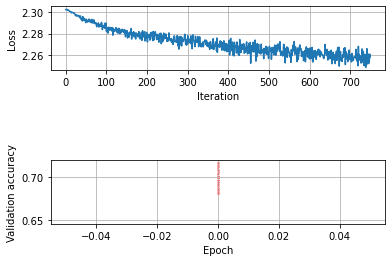

In [ ]:
def shuffle(X, Y):
    train_indices = np.arange(X.shape[0])
    np.random.shuffle(train_indices)
    X_result = X[train_indices,:, :]
    Y_result = Y[train_indices]
    return X_result, Y_result

def load_mnist_data():
    with open('mnist.pickle', 'rb') as f:
        print('Loading Pickled Data...')
        return pickle.load(f)

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

if __name__ == '__main__':
    # Clear old computational graphs
    tf.compat.v1.reset_default_graph()
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
    with tf.compat.v1.Session(config=config) as sess:

        (x_train, y_train), (x_test, y_test) = load_mnist_data()
        
        num_train = 48000
        num_val = 12000
        num_test = 10000
        # num_train = 500
        # num_val = 100
        # num_test = 1000
        x_train, y_train = shuffle(x_train, y_train)
        x_test, y_test = shuffle(x_test, y_test)
        x_val = x_train[-num_val::, :, :]
        y_val = y_train[-num_val::]
        x_train = x_train[0:num_train, :, :]
        y_train = y_train[0:num_train]
        x_test = x_test[0:num_test, :, :]
        y_test = y_test[0:num_test]   


        # # train all
        # x_val = x_train[-10000:, :, :].astype('float64')
        # y_val = y_train[-10000:].astype('float64')
        # xx_train = x_train[:-10000, :, :].astype('float64')
        # xy_train = np.zeros(xx_train.shape).astype('float64') + 1e-15
        # y_train = y_train[:-10000].astype('float64')
        # x_test = x_test.astype('float64')
        # y_test = y_test.astype('float64')

        #x_train, y_train = shuffle(x_train, y_train)
        #x_test, y_test = shuffle(x_test, y_test)

        #ts = 6000
        #x_val = x_train[-1200:, :, :].astype('float32')
        #y_val = y_train[-1200:].astype('float32')
        #x_train = x_train[:ts, :, :].astype('float32')
        #y_train = y_train[:ts].astype('float32')
        #x_test = x_test[:1200].astype('float32')
        #y_test = y_test[:1200].astype('float32')

        model = d2nn_model()

        sess.run(tf.compat.v1.global_variables_initializer())
        #variables_names = [v.name for v in tf.trainable_variables()]
        #values = sess.run(variables_names)
        #for k, v in zip(variables_names, values):
        #    print( "Variable: ", k)
        #    print("Shape: ", v.shape)
        #    print(v)

        model.train(sess, x_train, y_train, x_val, y_val)
        accuracy, confusion_matrix = model.evaluate(sess, x_test, y_test)
        print(confusion_matrix)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.compat.v1.train.Saver()
        model_path = saver.save(sess, "d2nn_model_amp.ckpt")
        print("Model saved in %s" % model_path)

In [ ]:
confusion_matrix

array([[9.600e+02, 1.000e+00, 2.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        7.000e+00, 1.000e+00, 2.000e+00, 0.000e+00],
       [0.000e+00, 1.127e+03, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.150e+02, 2.320e+02, 5.250e+02, 3.600e+01, 4.200e+01, 0.000e+00,
        1.800e+01, 2.500e+01, 3.600e+01, 0.000e+00],
       [4.900e+01, 5.000e+01, 7.000e+00, 8.620e+02, 7.000e+00, 0.000e+00,
        5.000e+00, 1.900e+01, 9.000e+00, 1.000e+00],
       [1.400e+01, 5.700e+01, 1.000e+00, 0.000e+00, 8.720e+02, 0.000e+00,
        1.400e+01, 1.000e+00, 1.000e+00, 2.200e+01],
       [2.480e+02, 1.080e+02, 0.000e+00, 3.550e+02, 3.700e+01, 5.000e+00,
        3.500e+01, 3.100e+01, 4.700e+01, 2.500e+01],
       [8.500e+01, 4.700e+01, 2.000e+00, 6.000e+00, 4.200e+01, 0.000e+00,
        7.730e+02, 0.000e+00, 0.000e+00, 0.000e+00],
       [4.100e+01, 8.500e+01, 7.000e+00, 0.000e+00, 2.900e+01, 0.000e+00,
        0.000e+00, 8.460e+02, 5.000e+

In [ ]:
with np.printoptions(precision=3, suppress=True):
    print(confusion_matrix/np.sum(confusion_matrix, axis = 0))

[[0.583 0.001 0.004 0.004 0.    0.    0.008 0.001 0.004 0.   ]
 [0.    0.57  0.004 0.001 0.    0.    0.002 0.    0.    0.   ]
 [0.07  0.117 0.958 0.025 0.031 0.    0.021 0.024 0.067 0.   ]
 [0.03  0.025 0.013 0.609 0.005 0.    0.006 0.018 0.017 0.002]
 [0.008 0.029 0.002 0.    0.645 0.    0.016 0.001 0.002 0.039]
 [0.15  0.055 0.    0.251 0.027 1.    0.04  0.029 0.088 0.044]
 [0.052 0.024 0.004 0.004 0.031 0.    0.887 0.    0.    0.   ]
 [0.025 0.043 0.013 0.    0.021 0.    0.    0.796 0.009 0.026]
 [0.055 0.111 0.002 0.097 0.024 0.    0.018 0.025 0.812 0.019]
 [0.027 0.025 0.002 0.008 0.214 0.    0.001 0.106 0.002 0.87 ]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


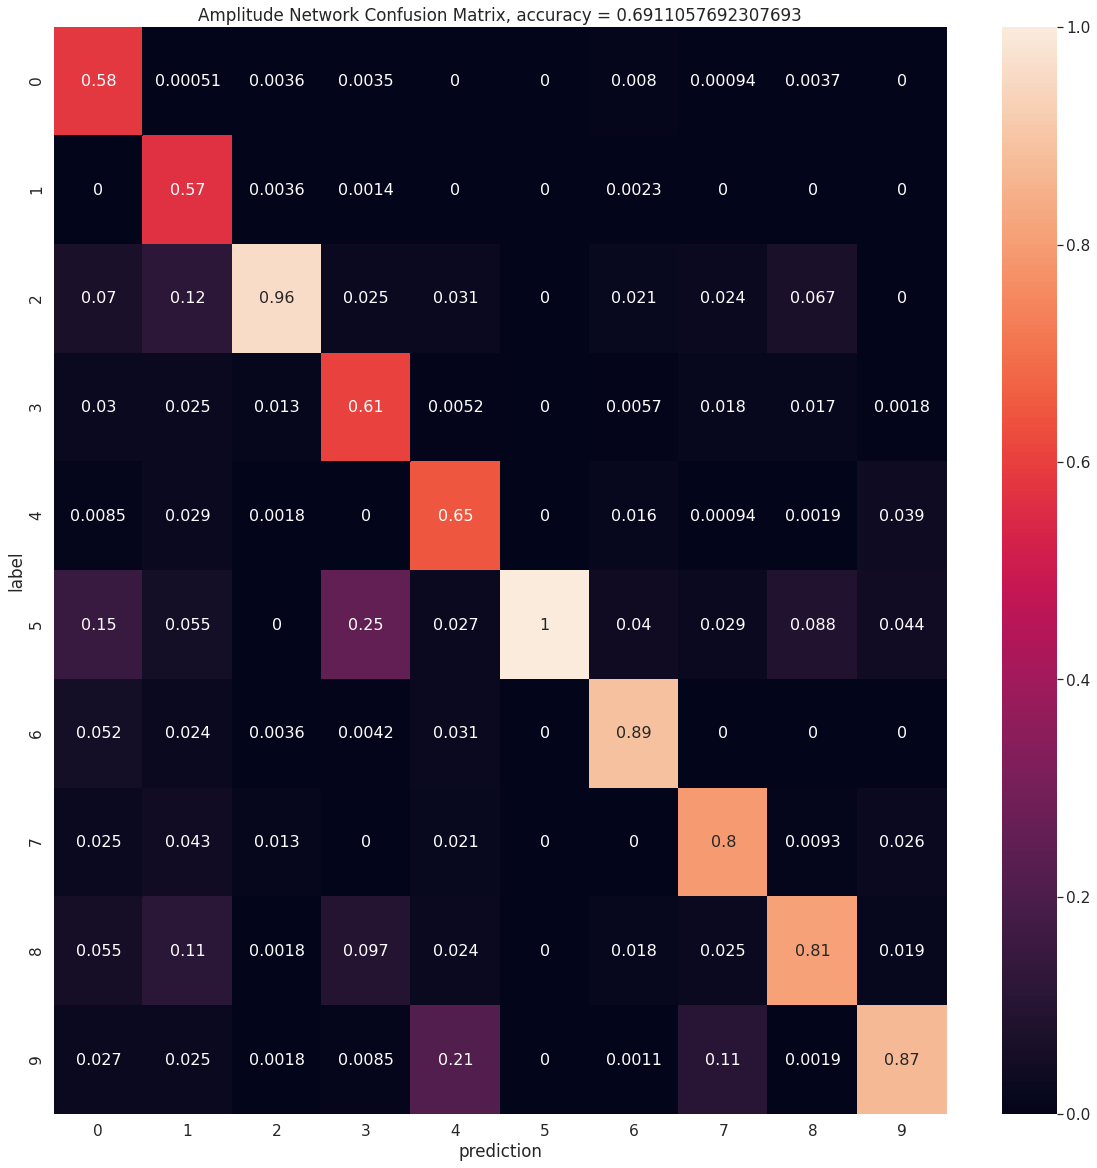

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(pd.DataFrame(confusion_matrix/np.sum(confusion_matrix, axis = 0), range(10), range(10)), annot=True, annot_kws={"size": 16}) # font size
ax.set(xlabel='prediction', ylabel='label', title = 'Amplitude Network Confusion Matrix, accuracy = ' + str(accuracy))
plt.show()
